In [1]:
import numpy as np
import math
import statsmodels.api as sm
import imblearn
from tqdm.notebook import tqdm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite, community 
from numpy import nansum
from numpy import nanmean
from numpy.random import choice
import itertools
from networkx.algorithms import community
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
cb1 = pd.read_csv('cb1.csv')
cb2 = pd.read_csv('cb2.csv')
cb3 = pd.read_csv('cb3.csv')

In [3]:
cb = cb1.append(cb2)
cb = cb.append(cb3)
cb.index = range(len(cb))

In [4]:
cb['date_my'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('m')
cb['date_y'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('y')

In [5]:
cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)

investor_continent  Africa   Asia  Australia  Europe  North America  \
target_continent                                                      
Africa                 269     53          3     123            116   
Asia                    34  19159         37     736           2464   
Australia                0     55        605      62            210   
Europe                  20    745         82   23014           3904   
North America           47   4081        331    6584          83604   
South America            0     14          4      99            203   

investor_continent  South America  
target_continent                   
Africa                          0  
Asia                            6  
Australia                       1  
Europe                         35  
North America                  57  
South America                 516

In [7]:
cb_a = cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)
cb_a["sum"] = cb_a.sum(axis = 0)
cb_a = cb_a.loc[:,"Africa":"South America"].div(cb_a["sum"], axis=1)
cb_a

investor_continent    Africa      Asia  Australia    Europe  North America  \
target_continent                                                             
Africa              0.727027  0.002199   0.002825  0.004017       0.001282   
Asia                0.091892  0.794748   0.034840  0.024038       0.027226   
Australia           0.000000  0.002281   0.569680  0.002025       0.002320   
Europe              0.054054  0.030904   0.077213  0.751649       0.043138   
North America       0.127027  0.169287   0.311676  0.215037       0.923791   
South America       0.000000  0.000581   0.003766  0.003233       0.002243   

investor_continent  South America  
target_continent                   
Africa                   0.000000  
Asia                     0.009756  
Australia                0.001626  
Europe                   0.056911  
North America            0.092683  
South America            0.839024

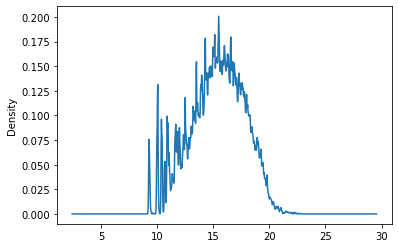

In [8]:
es1 = cb.groupby(['target_name','stage'], as_index = False).agg({"size_real": 'first'})
es2 = es1[['target_name','size_real']].groupby(['target_name'],as_index=False).sum()
es3 = es2[es2['size_real']!=0]
np.log(es3['size_real']).plot.kde(0.01)

In [9]:
#ordinare gli investitori

inv_list = list(cb['investors_name'].values)
inv_counter = {}
for inv in inv_list:
    if inv in inv_counter:
        inv_counter[inv] += 1
    else:
        inv_counter[inv] = 1

popular_invs = sorted(inv_counter, key = inv_counter.get, reverse = True)
 
top = popular_invs[:20]

In [10]:
nodes_org = cb[['target_name', 'target_ID']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb[['investors_name', 'investor_id']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry","investor_id":'index' })
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index
nodes

node     index  bipartite  \
0                                         Shionogi & Co.  262824.0          1   
1                                        Astellas Pharma  243168.0          1   
2                              Sumitomo Dainippon Pharma  447180.0          1   
3                                         Konica Minolta   57191.0          1   
4                                  Takeda Pharmaceutical  373007.0          1   
...                                                  ...       ...        ...   
83253  Shenzhen Qianhai Beizeng Asset Management Co. ...  179782.0          0   
83254                  Wuxi High-Tech District Seed Fund  189318.0          0   
83255                                    Edvantage Group  190377.0          0   
83256                                            Healgen       NaN          0   
83257                        Streamline Health Solutions  152741.0          0   

          id  
0          0  
1          1  
2          2  
3          3  
4          4  
...      ...  
83253  83253  
83254  83254  
83255  83255  
83256  83256  
83257  83257  

[83258 rows x 4 columns]

In [11]:
numbers = cb.groupby(['target_name','stage'], as_index = False).count()[['target_name','stage','investors_name']].rename(columns={"investors_name": "investor_numbers"})

In [12]:
cb_new = pd.merge(cb, numbers,  how='left', left_on=['target_name','stage'], right_on = ['target_name','stage'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 1],  how='left', left_on=['target_name','target_ID'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 0],  how='left', left_on=['investors_name','investor_id'], right_on = ['node','index'])


In [13]:
##ripeto quanto fatto prima (semplificato prima per risparmiare tempo) ma aggiungo roba
nodes_org = cb_new[['target_name', 'target_ID', 'target_country', 'target_continent',
               'industry','target_founded','target_status']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb_new[['investors_name', 'investor_id', 'investor_country', 'investor_continent', 'investor_type',
                   'investor_founded']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index", "target_founded":"foundation"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry", "investor_id":'index',
                                     "investor_founded":"foundation"})
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index
nodes.columns



Index(['node', 'index', 'country', 'continent', 'industry', 'foundation',
       'target_status', 'bipartite', 'id'],
      dtype='object')

In [14]:
B = nx.MultiGraph(name='org-bid')
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(nodes[nodes.bipartite==0].id)
B.add_nodes_from(nodes[nodes.bipartite==1].id)
nx.set_node_attributes(B, pd.Series(nodes.node, index=nodes.id).to_dict(), 'name')
nx.set_node_attributes(B, pd.Series(nodes.country, index=nodes.id).to_dict(), 'country')
nx.set_node_attributes(B, pd.Series(nodes.continent, index=nodes.continent).to_dict(), 'continent')
nx.set_node_attributes(B, pd.Series(nodes.industry, index=nodes.id).to_dict(), 'industry')
nx.set_node_attributes(B, pd.Series(nodes.foundation, index=nodes.id).to_dict(), 'foundation')
nx.set_node_attributes(B, pd.Series(nodes.bipartite, index=nodes.id).to_dict(), 'bipartite')
nx.set_node_attributes(B, pd.Series(nodes.target_status, index=nodes.id).to_dict(), 'target_status')
# Add edges only between nodes of opposite node sets
for i in range(len(cb_new)):
    B.add_edge(cb_new.loc[i,'id_y'], cb_new.loc[i,'id_x'], date=(cb_new.loc[i,'date_y']).year, m_raised=cb_new.loc[i,'size_real'], 
               investors = cb_new.loc[i,'investor_numbers'], round_simp =cb_new.loc[i,'round_simp'])

In [15]:
brutti = [x for x,y in B.nodes(data=True) if (y['name']=='Undisclosed Investors') or (y['name']=='Dead')   or (y['name']=='Public')  
          or  (y['name']=='Undisclosed Angel Investors') or (y['name']=='Undisclosed Venture Investors')]
B.remove_nodes_from(brutti)

In [16]:
bid_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
org_nodes = set(B) - bid_nodes

In [17]:
id_round = cb_new[['target_ID','round_simp']]
id_round = id_round.drop_duplicates()
id_round.index = range(len(id_round))
id_round['id_round'] = id_round.index
id_round

id_year = cb_new[['target_ID','date_y']]
id_year = id_year.drop_duplicates()
id_year.index = range(len(id_year))
id_year['id_year'] = id_year.index
id_year

target_ID date_y  id_year
0         262824   1949        0
1         243168   1949        1
2         447180   1949        2
3          57191   1949        3
4         373007   1949        4
...          ...    ...      ...
94835     669346   2021    94835
94836     377820   2021    94836
94837     439295   2021    94837
94838     439775   2021    94838
94839     669451   2021    94839

[94840 rows x 3 columns]

In [18]:
cb_new = pd.merge(cb_new, id_round,  how='left', left_on=['target_ID','round_simp'], right_on = ['target_ID','round_simp'])


In [19]:
cb_new = pd.merge(cb_new, id_year,  how='left', left_on=['target_ID','date_y'], right_on = ['target_ID','date_y'])

In [20]:
nodes_inv = nodes[nodes['bipartite']==0]

In [21]:
##bidbid in stesso anno
links = []
subcb = cb_new[['id_year','date_y','id_y']].drop_duplicates()
subcb = subcb[pd.notna(subcb['date_y'])]
for i in tqdm(subcb['id_year'].unique()):
    subcb2 = subcb[subcb['id_year']==i]
    for couple in itertools.combinations(np.unique(subcb2['id_y'].values),2):
        links.append((couple + ({'date': subcb2['date_y'].values[0].year},)))


In [22]:
bidbid=nx.MultiGraph()
bidbid.add_nodes_from(nodes[nodes.bipartite==0].id)
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.node, index=nodes_inv.id).to_dict(), 'name')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.country, index=nodes_inv.id).to_dict(), 'country')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.continent, index=nodes_inv.id).to_dict(), 'continent')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.industry, index=nodes_inv.id).to_dict(), 'industry')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.foundation, index=nodes_inv.id).to_dict(), 'foundation')
nx.set_node_attributes(bidbid, pd.Series(nodes_inv.bipartite, index=nodes_inv.id).to_dict(), 'bipartite')
bidbid.add_edges_from(links) 
remove = [node for node,degree in dict(bidbid.degree()).items() if degree == 0]
bidbid.remove_nodes_from(remove)
bidbid.remove_nodes_from(brutti)
nx.readwrite.write_gpickle(bidbid,'bidbid_cb.gpickle')
nx.info(bidbid)

'Name: \nType: MultiGraph\nNumber of nodes: 21902\nNumber of edges: 250433\nAverage degree:  22.8685'

In [26]:
nx.write_gexf(bidbid, 'bidbid.gexf')

In [27]:
B = nx.MultiGraph(name='org-bid')
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(nodes[nodes.bipartite==0].id)
B.add_nodes_from(nodes[nodes.bipartite==1].id)
nx.set_node_attributes(B, pd.Series(nodes.node, index=nodes.id).to_dict(), 'name')
nx.set_node_attributes(B, pd.Series(nodes.country, index=nodes.id).to_dict(), 'country')
nx.set_node_attributes(B, pd.Series(nodes.continent, index=nodes.continent).to_dict(), 'continent')
nx.set_node_attributes(B, pd.Series(nodes.industry, index=nodes.id).to_dict(), 'industry')
nx.set_node_attributes(B, pd.Series(nodes.foundation, index=nodes.id).to_dict(), 'foundation')
nx.set_node_attributes(B, pd.Series(nodes.bipartite, index=nodes.id).to_dict(), 'bipartite')
nx.set_node_attributes(B, pd.Series(nodes.target_status, index=nodes.id).to_dict(), 'target_status')
# Add edges only between nodes of opposite node sets
cb_new_dates = cb_new[pd.notna(cb_new['date_y'])]
cb_new_dates.index = range(len(cb_new_dates)) 
for i in range(len(cb_new_dates)):
    B.add_edge(cb_new_dates.loc[i,'id_y'], cb_new_dates.loc[i,'id_x'], date=(cb_new_dates.loc[i,'date_y']).year, m_raised=cb_new_dates.loc[i,'size_real'], 
               investors = cb_new_dates.loc[i,'investor_numbers'], round_simp =cb_new_dates.loc[i,'round_simp'])
brutti = [x for x,y in B.nodes(data=True) if (y['name']=='Undisclosed Investors') or (y['name']=='Dead')   or (y['name']=='Public')  
          or  (y['name']=='Undisclosed Angel Investors') or (y['name']=='Undisclosed Venture Investors')]
B.remove_nodes_from(brutti)
remove = [node for node,degree in dict(B.degree()).items() if degree == 0]
B.remove_nodes_from(remove)
bid_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
org_nodes = set(B) - bid_nodes

In [28]:
def project_multi(B, nodes, name):
    G=nx.MultiGraph(name=name)
    count=0
    for node in tqdm(nodes):
        ego=nx.ego_graph(B, node)
        ndx=list(ego.nodes())
        ndx.remove(node)
        for year in range(1970,2022): # bad trick to link depending on year
            subndx=[x for x in ndx if [y for y in list(ego.edges(data=True)) if y[0]==x or y[1]==x][0][2]['date']==year]
            for couple in itertools.combinations(subndx, 2):
                if G.has_edge(couple[0], couple[1]):
                    continue
                G.add_edge(couple[0], couple[1], anno = year)
        count+=1
        if count%1000==0:
            print(count, end=' ')
    return G

In [ ]:
orgorg = project_multi(B, bid_nodes, 'orgorg')

In [79]:
orgorg2010 = nx.read_gpickle(r'C:\Users\Marco\Documents\GitHub\crunch_net\notebook\orgorg_single_\orgorg_single2010.gpickle')

In [70]:
orgorg2020.edges.data()

EdgeDataView([(16418, 16949, {'date': [2011]}), (16418, 15927, {'date': [2011]}), (16418, 15147, {'date': [2011]}), (16418, 16009, {'date': [2011]}), (16418, 16237, {'date': [2011]}), (16418, 15085, {'date': [2011]}), (16949, 15927, {'date': [2011]}), (16949, 16154, {'date': [2011]}), (16949, 15850, {'date': [2011]}), (16949, 16237, {'date': [2011]}), (16949, 16637, {'date': [2011]}), (16949, 11535, {'date': [2011]}), (16949, 14105, {'date': [2011]}), (16949, 16596, {'date': [2011]}), (15927, 16648, {'date': [2011]}), (15927, 16546, {'date': [2011]}), (15927, 14757, {'date': [2011]}), (15927, 16596, {'date': [2011]}), (15927, 15905, {'date': [2011]}), (15927, 16237, {'date': [2011]}), (15927, 8908, {'date': [2013]}), (15927, 17873, {'date': [2013]}), (15147, 26251, {'date': [2015]}), (15147, 25015, {'date': [2015]}), (15147, 24674, {'date': [2015]}), (16009, 8640, {'date': [2012]}), (16009, 21061, {'date': [2014]}), (16009, 18117, {'date': [2014]}), (16009, 13657, {'date': [2014]}), (1

In [41]:
nodes

node     index  \
0                                         Shionogi & Co.  262824.0   
1                                        Astellas Pharma  243168.0   
2                              Sumitomo Dainippon Pharma  447180.0   
3                                         Konica Minolta   57191.0   
4                                  Takeda Pharmaceutical  373007.0   
...                                                  ...       ...   
83253  Shenzhen Qianhai Beizeng Asset Management Co. ...  179782.0   
83254                  Wuxi High-Tech District Seed Fund  189318.0   
83255                                    Edvantage Group  190377.0   
83256                                            Healgen       NaN   
83257                        Streamline Health Solutions  152741.0   

             country      continent                     industry  foundation  \
0              Japan           Asia      Pharmaceuticals / Drugs      1878.0   
1              Japan           Asia      Pharmaceuticals / Drugs      1923.0   
2              Japan           Asia      Pharmaceuticals / Drugs      1897.0   
3              Japan           Asia  Medical Devices & Equipment      1936.0   
4              Japan           Asia      Pharmaceuticals / Drugs      1781.0   
...              ...            ...                          ...         ...   
83253          China           Asia              Venture Capital      2016.0   
83254          China           Asia                        Other         NaN   
83255          China           Asia                  Corporation      2015.0   
83256            NaN            NaN                          NaN         NaN   
83257  United States  North America                  Corporation         NaN   

           target_status  bipartite     id  
0      IPO / Went public          1      0  
1      IPO / Went public          1      1  
2      IPO / Went public          1      2  
3      IPO / Went public          1      3  
4      IPO / Went public          1      4  
...                  ...        ...    ...  
83253                NaN          0  83253  
83254                NaN          0  83254  
83255                NaN          0  83255  
83256                NaN          0  83256  
83257                NaN          0  83257  

[83258 rows x 9 columns]

In [80]:
nx.set_node_attributes(orgorg2010, pd.Series(nodes.node, index=nodes.id).to_dict(), 'name')
nx.set_node_attributes(orgorg2010, pd.Series(nodes.country, index=nodes.id).to_dict(), 'country')
nx.set_node_attributes(orgorg2010, pd.Series(nodes.continent, index=nodes.id).to_dict(), 'continent')
nx.set_node_attributes(orgorg2010, pd.Series(nodes.industry, index=nodes.id).to_dict(), 'industry')
nx.set_node_attributes(orgorg2010, pd.Series(nodes.foundation, index=nodes.id).to_dict(), 'foundation')
nx.set_node_attributes(orgorg2010, pd.Series(nodes.bipartite, index=nodes.id).to_dict(), 'bipartite')

In [82]:
nx.write_gexf(orgorg2010, 'orgorg2010.gexf')

In [81]:
for i in orgorg2010.edges.data():
    i[2]['date'] = (i[2]['date'][0])

In [77]:
for i in orgorg2020.edges.data():
    print(i[2]['date'])

2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2013
2013
2015
2015
2015
2012
2014
2014
2014
2014
2012
2012
2017
2017
2011
2011
2011
2011
2015
2020
2011
2011
2011
2012
2012
2012
2012
2012
2012
2012
2018
2017
2019
2013
2013
2013
2013
2018
2018
2015
2015
2013
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2014
2014
2011
2011
2011
2011
2011
2011
2011
2014
2014
2011
2011
2011
2013
2013
2013
2013
2013
2014
2013
2013
2011
2011
2013
2013
2013
2013
2013
2013
2013
2013
2011
2011
2011
2011
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2011
2011
2011
2011
2011
2013
2013
2014
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2013
2011
2011
2013
2013
2013
2013
2013
2013
2011
2011
2011
2011
2011
2014
2014
2014
2014
2014
2014
2014
2014
2014
2014
2014
2014
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2012
2014
2014
2014
2014
2012
2013
2012
2012
2012
2012
2015
2015
2015
2015
2015
2017
2012
2012
2017
2017


2015
2018
2018
2018
2018
2018
2013
2013
2012
2012
2012
2012
2015
2015
2014
2015
2014
2014
2014
2013
2014
2014
2014
2014
2014
2020
2020
2013
2015
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2011
2013
2011
2011
2014
2014
2018
2014
2014
2014
2014
2014
2014
2014
2014
2014
2011
2011
2011
2018
2011
2011
2015
2015
2015
2015
2015
2015
2016
2013
2013
2016
2016
2019
2016
2013
2016
2012
2012
2019
2019
2019
2016
2016
2016
2016
2011
2012
2013
2013
2013
2013
2013
2016
2016
2016
2016
2016
2016
2016
2016
2019
2019
2019
2013
2013
2013
2013
2013
2013
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2017
2013
2013
2015
2013
2013
2013
2015
2017
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2018
2018
2013
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2013
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018


2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2018
2018
2018
2018
2020
2020
2020
2018
2018
2018
2020
2020
2016
2015
2014
2015
2016
2014
2015
2015
2015
2016
2016
2016
2016
2015
2016
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2016
2016
2014
2014
2014
2014
2014
2014
2014
2014
2016
2016
2016
2016
2016
2016
2016
2015
2015
2015
2015
2015
2018
2020
2020
2020
2020
2020
2020
2020
2018
2020
2018
2020
2020
2018
2018
2017
2020
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2015
2018
2015
2015
2018
2018
2018
2018
2018
2018
2018
2018
2017
2017
2017
2015
2015
2015
2015
2015
2015
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2015
2015
2015
2015
2015
2017
2019


2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2017
2013
2013
2013
2017
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2017
2017
2017
2017
2017
2018
2017
2017
2017
2017
2015
2018
2015
2017
2017
2018
2018
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2018
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2018
2018
2018
2018
2018
2018
2018
2018
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2019
2013
2019
2013
2013
2019
2019
2013
2013
2019
2019
2019
2019
2019
2019
2019
2019
2013
2013
2013
2013
2013
2013
2013
2013
2013
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019


2016
2016
2019
2016
2016
2018
2018
2016
2016
2016
2016
2018
2018
2016
2018
2018
2019
2016
2018
2016
2016
2016
2019
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2016
2016
2016
2016
2011
2016
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2015
2015
2015
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2018
2018
2018
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2018
2018
2018
2018
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020


2018
2020
2020
2020
2020
2020
2020
2020
2020
2018
2020
2020
2020
2018
2020
2020
2020
2016
2020
2020
2020
2018
2018
2020
2020
2020
2020
2020
2020
2020
2020
2018
2020
2018
2016
2020
2020
2018
2020
2020
2018
2016
2020
2020
2020
2020
2020
2020
2020
2020
2020
2016
2016
2016
2020
2018
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2020
2020
2020
2020
2020
2020
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2018
2018
2018
2018
2018
2018
2020
2020
2020
2020
2018
2020
2020
2020
2020
2020
2018
2017
2017
2017
2017
2017
2018
2020
2020
2020
2017
2017
2017
2017
2017
2017
2017
2017
2018
2020
2018
2020
2020
2020
2020
2020
2020
2020
2020


2020
2020
2020
2020
2020
2020
2018
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2020
2020
2020
2020
2020
2020
2020
2018
2020
2020
2018
2020
2018
2020
2018
2020
2020
2018
2018
2020
2020
2020
2018
2018
2018
2018
2020
2018
2018
2018
2020
2020
2020
2020
2018
2018
2018
2018
2020
2020
2020
2020
2017
2020
2020
2020
2017
2017
2017
2017
2017
2017
2020
2020
2020
2020
2020
2020
2020
2020
2018
2020
2020
2018
2020
2016
2020
2020
2020
2020
2016
2016
2016
2016
2020
2020
2016
2016
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2015
2020
2020
2020
2018
2020
2020
2020
2020
2015
2015
2015
2016
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2018
2018
2018
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020


2014
2014
2014
2014
2016
2014
2014
2014
2014
2014
2014
2014
2014
2016
2018
2018
2018
2016
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2016
2018
2016
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2016
2016
2018
2018
2016
2020
2016
2016
2016
2016
2016
2016
2020
2016
2016
2020
2016
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2016
2016
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2011
2015
2015
2014
2011
2011
2015
2011
2011
2011
2011
2011
2015
2015
2014
2015
2011
2011
2011
2015
2011
2011
2011
2011
2015
2015
2019
2015
2015
2015
2015
2015
2015
2014
2015
2015
2014
2015
2015
2015
2015


2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2019
2018
2018
2018
2018
2018
2018
2020
2018
2018
2018
2018
2018
2018
2018
2016
2018
2018
2018
2016
2018
2018
2018
2018
2018
2020
2020
2018
2018
2018
2016
2018
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2018
2018
2018
2018
2020
2020
2020
2018
2018
2018
2018
2018
2015
2020
2014
2018
2018
2015
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2015
2018
2015
2018
2015
2015
2018
2015
2018
2018
2018
2018
2015
2018
2018
2018
2018
2018
2015
2015
2015
2015
2015
2018
2018
2018
2018
2018
2018
2018
2018
2018
2015
2015
2020
2020
2020
2020
2020
2018
2018
2018
2018
2018
2014
2014
2014
2014
2014
2014
2014
2018
2018
2018
2018
2018
2018
2018
2015
2015
2015
2015
2018
2018
2018
2018
2017
2017
2017
2015


2019
2020
2020
2020
2020
2020
2019
2020
2019
2020
2019
2020
2019
2019
2019
2019
2019
2020
2020
2020
2020
2019
2020
2020
2019
2020
2019
2019
2019
2020
2020
2020
2020
2020
2019
2019
2019
2020
2020
2020
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2019
2020
2020
2020
2020
2020
2020
2020
2018
2018
2018
2018
2018
2018
2015
2015
2015
2015
2015
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2018
2018
2018
2018
2018
2014
2014
2014
2014
2014
2014
2014
2014
2016
2016
2018
2020
2020
2018
2020
2020
2020
2020
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2020
2020
2018
2018
2018
2018
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2019
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020


2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2011
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2020
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2017
2018
2018
2017
2018
2018
2018
2018
2018
2017
2018
2017
2017
2017
2018
2018
2018
2018
2018
2018
2017
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2019
2019
2018
2018
2018
2018
2018
2019
2019
2018
2019
2019
2019
2019
2019
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2017
2017
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018


2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2020
2020
2020
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2016
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2018
2018
2016
2018
2018
2018
2017
2018
2018
2018
2018
2018
2017
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2017
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2018
2018
2018
2018
2018
2018
2018
2018
2018
2019
2017
2019
2019
2019
2019
2019
2019
2019
2019
2019
2017


2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2019
2019
2019
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2016
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2019
2019
2019
2019
2017
2017
2019
2017
2017
2017
2017
2017
2017
2017
2017
2018
2018
2018
2017
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2016
2016
2016
2016
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017


2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2017
2015
2015
2017
2017
2017
2017
2017
2015
2017
2015
2015
2017
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2017
2017
2017
2017
2017
2019
2019
2019
2019
2014
2019
2019
2017
2019
2019
2019
2017
2017
2017
2019
2015
2019
2019
2019
2019
2015
2016
2017
2015
2019
2019
2014
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2015
2014
2014
2014
2014
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019


2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2019
2020
2018
2018
2019
2020
2019
2020
2020
2019
2019
2020
2020
2020
2020
2020
2020
2020
2020
2020
2019
2019
2019
2019
2019
2019
2019
2019
2019
2020
2018
2019
2019
2018
2018
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2018
2018
2018
2018
2018
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020


2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2016
2016
2016
2016
2016
2016
2016
2017
2018
2018
2018
2017
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2018
2019
2017
2019
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2018
2015
2015
2017
2015
2015
2015
2017
2015
2017
2017
2015
2015
2017
2018
2015
2015
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2015
2018
2017
2017
2017
2017
2017
2017
2017
2019
2019
2019
2019
2017
2017
2017
2017
2017
2017
2020
2020
2020
2020
2020
2018
2018
2018
2018
2017
2018
2017
2017
2017
2017
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2019
2020
2020
2018
2018
2018
2018
2017
2020
2020
2018
2018
2020
2020
2020
2020
2018
2020
2015
2018
2018
2018
2018
2018
2018


2017
2017
2017
2017
2018
2018
2018
2018
2018
2018
2018
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2019
2019
2017
2017
2018
2018
2018
2018
2018
2018
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2018
2018
2018
2018
2018
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2019
2018
2018
2018
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2018
2018
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2018
2018
2017
2017
2017
2018
2018
2018
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2016
2015
2015
2015
2015
2015
2015
2016
2016
2016
2016
2016


2019
2019
2019
2019
2019
2019
2019
2019
2019
2017
2019
2019
2019
2019
2019
2019
2017
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2017
2017
2017
2017
2017
2017
2017
2017
2019
2019
2020
2019
2019
2020
2020
2020
2020
2020
2019
2019
2019
2019
2019
2019
2020
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019


2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2017
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2017
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2013
2013
2016
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2013
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016
2016


2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2020
2020
2020
2018
2018
2020
2020
2020
2018
2019
2020
2018
2020
2019
2018
2020
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2020
2020
2020
2018
2018
2018
2020
2020
2020
2020
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2019
2019
2019
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2020
2020
2020
2020
2020
2020
2020
2020
2019
2019
2019
2019
2019
2019
2018
2018
2019
2019
2018
2019
2018
2018
2018
2019
2018
2019
2018
2019
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2018
2018
2019
2019
2019
2019
2019
2019
2019
2020
2020
2020
2019
2020
2019
2020
2020
2019
2019
2019
2019
2020
2019
2019
2019
2019
2019
2019
2020
2019
2019
2019
2019
2019
2019
2019
2019
2019
2020
2020
2020
2020
2020
2020
2020
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019


2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2019
2015
2015
2019
2017
2019
2019
2017
2019
2017
2019
2019
2019
2019
2019
2019
2017
2017
2019
2019
2018
2018
2019
2019
2018
2018
2018
2016
2018
2018
2018
2018
2019
2018
2019
2019
2018
2019
2019
2019
2018
2017
2017
2017
2015
2015
2019
2018
2018
2018
2018
2018
2018
2017
2017
2015
2019
2019
2019
2015
2015
2015
2015
2015
2015
2014
2015
2015
2015
2015
2015
2015
2015
2015
2014
2014
2014
2014
2014
2014
2016
2016
2016
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018


2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2018
2017
2018
2017
2017
2017
2018
2018
2018
2017
2017
2017
2017
2017
2017
2017
2019
2019
2018
2018
2018
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2020
2019
2014
2020
2019
2019
2019
2020
2014
2019
2014
2020
2014
2019
2019
2019
2019
2014
2014
2014
2014
2014
2020
2020
2020
2020
2020
2020
2020
2019
2019
2019
2020
2020
2020
2020
2016
2011
2019
2011
2012
2012
2019
2019
2019
2019
2019
2020
2012
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2017
2020
2018
2018
2020
2020
2020
2012
2019
2012
2019
2019
2019
2012
2012
2012
2012
2011
2011
2011
2013
2011
2017
2017
2018
2020
2020
2018
2018
2020
2018
2020
2020
2020
2020
2020
2018
2018
2018
2018
2017
2017
2017
2017
2017
2017
2017
2017
2020
2020
2017
2017
2020
2019
2019
2019
2020
2019
2020
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2020
2019
2019
2019
2019
2019
2019
2019
2019
2019


2020
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2020
2020
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2018
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020


2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2014
2014
2014
2014
2014
2014
2019
2019
2019
2019
2019
2019
2019
2019
2017
2017
2017
2017
2017
2017
2018
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2018
2018
2018
2018
2018
2018
2018
2017
2017
2017
2017
2017
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2017
2017
2017
2017
2019
2019
2017
2019
2019
2019
2017
2017
2017
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2017
2017
2017
2020
2020
2020
2017
2017
2017
2017
2019
2019
2019
2019
2019
2019
2016
2016
2015
2019
2015
2017
2019
2019
2019
2019


2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2018
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2017
2019
2012
2014
2019
2019
2014
2019
2019
2012
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2019
2012
2019
2019
2019
2019
2013
2013
2017
2013
2013
2017
2013
2017
2019
2017
2017
2017
2017
2017
2017
2017
2017
2017
2013
2013
2013
2013
2019
2019


2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020
2020


KeyboardInterrupt: 